In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from random import randint

In [2]:
F1 = 4
F2 = 32
F3 = 64
F4 = 128

In [3]:
from load_dataset import load_dataset, plot_image

device = "cpu"

pimages = load_dataset().to(device)

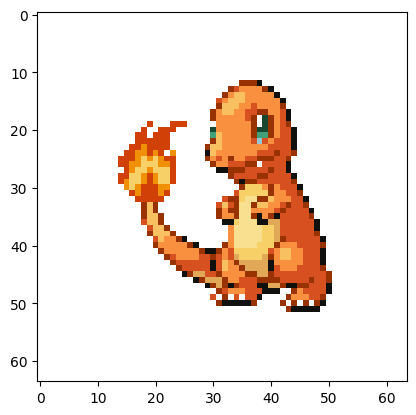

In [15]:
plot_image(pimages[2][3])

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.double_conv = nn.Sequential(
            
            nn.Conv2d(in_c, out_c, kernel_size=3, padding='same', bias=False),
            nn.GroupNorm(1, out_c),
            nn.GELU(),
            
            nn.Conv2d(out_c, out_c, kernel_size=3, padding='same', bias=False),
            nn.GroupNorm(1, out_c),
            nn.GELU(),
        
        )

    def forward(self, x):
        return self.double_conv(x)
        
class DoubleResidualConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.double_conv = nn.Sequential(
            
            nn.Conv2d(in_c, out_c, kernel_size=3, padding='same', bias=False),
            nn.GroupNorm(1, out_c),
            nn.GELU(),
            
            nn.Conv2d(out_c, out_c, kernel_size=3, padding='same', bias=False),
            nn.GroupNorm(1, out_c),
        
        )

    def forward(self, x):
        return F.gelu(x + self.double_conv(x))

In [6]:
class SConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.sconv = nn.Conv2d(in_c, out_c,
                               kernel_size=3, 
                               stride=2, 
                               padding = 1)
    
    def forward(self, x):
        return F.gelu(self.sconv(x))
    
class TConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.tconv = nn.ConvTranspose2d(in_c, out_c,
                                  kernel_size=3, 
                                  stride=2, 
                                  padding = 1, 
                                  output_padding=1)
    
    def forward(self, x):
        return F.gelu(self.tconv(x))

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs1 = nn.Sequential(
            DoubleConv(F1, F2),
            SConv(F2, F2),
            DoubleResidualConv(F2, F2),
        )
        self.convs2 = nn.Sequential(
            DoubleConv(F2, F3),
            SConv(F3, F3),
            DoubleResidualConv(F3, F3),
        )
        self.convs3 = nn.Sequential(
            DoubleConv(F3, F4),
            SConv(F4, F4),
            DoubleResidualConv(F4, F4),
        )
        
    def forward(self, x):
        x = self.convs1(x)
        x = self.convs2(x)
        x = self.convs3(x)
        
        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.tconv1 = nn.Sequential(
            DoubleResidualConv(F4, F4),
            TConv(F4, F4),
            DoubleConv(F4, F3),
        )
        self.tconv2 = nn.Sequential(
            DoubleResidualConv(F3, F3),
            TConv(F3, F3),
            DoubleConv(F3, F2),
        )
        self.tconv3 = nn.Sequential(
            DoubleResidualConv(F2, F2),
            TConv(F2, F2),
            DoubleConv(F2, F1)
        )
        
        
    def forward(self, x):
        x = self.tconv1(x)
        x = self.tconv2(x)
        x = self.tconv3(x)
        
        return x

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [9]:
class MultiEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.scaler = nn.Sequential(
            DoubleConv(4, 16),
            
            DoubleConv(16, 16),
            DoubleResidualConv(16, 16),
            TConv(16, 16),
            
            DoubleConv(16, 16),
            DoubleConv(16, 8),
            #DoubleConv(8, 1),
        )
        self.descaler = nn.Sequential(
            #DoubleConv(1, 8),
            DoubleConv(8, 16),
            DoubleConv(16, 16),

            SConv(16, 16),
            DoubleResidualConv(16, 16),
            DoubleConv(16, 16),

            nn.Conv2d(16, 4, kernel_size=1),
        )
        
        
    def forward(self, x):
        x = self.scaler(x)
        x = self.descaler(x)
        
        return x

In [ ]:
pimages = pimages.to("cuda")
model = MultiEncoder().to("cuda")

loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.5e-2)

pbar = tqdm(range(5001))
def closure():
    optimizer.zero_grad()

    source = randint(0, 2)
    batch = torch.randperm(385)[:4]

    img  = pimages[source][batch]
    pred = model(img)
    
    loss = loss_func(img, pred)
    loss.backward()

    pbar.set_description(f"%.8f" % loss)

    return loss



model.train()

for j in pbar:
    optimizer.step(closure)

model.eval();

0.06097761:  37%|██████████                 | 1873/5001 [01:06<01:50, 28.23it/s]

In [ ]:
plot_image(model(pimages[0][9][None])[0])

In [ ]:
plot_image(model.scaler(pimages[0][277][None])[0][[0,0,0,0]])